In [3]:
from __future__ import annotations

from typing import Any, cast
import json

In [4]:
%matplotlib widget

from matplotlib import pyplot as plt, ticker, backend_bases
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.patches import FancyBboxPatch
from mpl_interactions import zoom_factory

In [5]:
# from matplotlib.widgets import Slider
# class ScrollSlider(Slider):
#     def __init__(self, maxis: Axes, ax: Axes, label, valmin, valmax, valinit):
#         super().__init__(ax, label, valmin, valmax, valinit=valinit)
#         self.maxis = maxis
#         self.fig = ax.get_figure()
#         self.on_changed(self._scroll)

#     def _scroll(self, val):
#         pos = val
#         self.maxis.set_xlim(pos, pos + 100)
#         self.fig.canvas.draw()  # type:ignore

#     @classmethod
#     def from_ax_fig(cls, fig: Figure, ax: Axes) -> ScrollSlider:
#         slider_pos = fig.add_axes((0.13, 0.02, 0.757, 0.01))
#         # spos = ScrollSlider(ax, slider_pos, "", 0, 1000, valinit=0)
#         spos = ScrollSlider(maxis=ax, ax=slider_pos, label="", valmin=0, valmax=1000, valinit=0)
#         return spos

In [6]:
class Annotater:
    def __init__(
        self,
        ax: Axes,
        collections: list[PolyCollection | PathCollection],
        collection_data: dict[PolyCollection | PathCollection, dict],
    ):
        self.ax = ax
        self.collections = collections
        self.collection_data = collection_data
        self.annotater = self.ax.annotate(
            "",
            xy=(0, 0),
            xytext=(0, 0),
            textcoords="offset points",
            bbox=dict(boxstyle="round", fc="yellow", ec="b", lw=2),
            # arrowprops=dict(arrowstyle="->"),
        )
        self.annotater.set_visible(False)
        self.ax.get_figure().canvas.mpl_connect(  # type:ignore
            "motion_notify_event", self
        )

    def __call__(self, event: backend_bases.Event) -> Any:

        # inline function ---

        def annotate(
            container: PolyCollection | PathCollection, event: backend_bases.MouseEvent
        ):
            if isinstance(container, PolyCollection):
                self.annotater.xy = event.xdata, event.ydata  # type:ignore
                # box = container.get_paths()[0].get_extents()
                # text = f"duration:{box.x1 - box.x0:.2f} {json.dumps(self.collection_data.get(container, {}))}"
                text = f"{json.dumps(self.collection_data.get(container, {}).get('event_name', {}))}"
                self.annotater.set_text(text)
                if bbox := self.annotater.get_bbox_patch():
                    bbox.set_alpha(0.5)
                return

            if isinstance(container, PathCollection):
                self.annotater.xy = event.xdata, event.ydata  # type:ignore
                # box = container.get_paths()[0].get_extents()
                # text = f"duration:{box.x1 - box.x0:.2f} {json.dumps(self.collection_data.get(container, {}))}"
                text = f"{json.dumps(self.collection_data.get(container, {}).get('event_name', {}))}"
                self.annotater.set_text(text)
                if bbox := self.annotater.get_bbox_patch():
                    bbox.set_alpha(0.5)
                return

        # inline function ---

        if isinstance(event, backend_bases.MouseEvent):
            for container in self.collections:
                contains, _ = container.contains(event)
                if contains:
                    container.set_alpha(0.8)
                    annotate(container, event)
                    self.annotater.set_visible(True)
                    break
                else:
                    container.set_alpha(1)
                    self.annotater.set_visible(False)

        self.ax.get_figure().canvas.draw_idle()  # type:ignore

In [7]:
class Render:
    def __init__(self, ax: Axes, simulation_log: str):

        self.axes = ax
        self.fig = cast(Figure, ax.get_figure())

        self.axes.set_ylim(1, 15)
        self.axes.set_xlim(-1, 1050)
        self.axes.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
        self.axes.set_xlabel("Minutes from Start")

        self.bars_list: list[PolyCollection] = []  # individual barh collections
        self.markers_list: list[PathCollection] = []
        self.map_collection_id_data: dict[PolyCollection | PathCollection, dict] = (
            dict()
        )

        with open(simulation_log, "r") as file:
            self.event_logs = json.load(file)

        for idx, task in enumerate(self.event_logs["logs"]):
            for event in task["task_events"]:
                if event["event_type"] == "job":
                    bar_ = self.axes.broken_barh(
                        [(event["event_start_timestamp"], event["event_lenght"])],
                        ((idx + 1) * 2, 1),
                        alpha=0.3,
                        facecolors=("tab:red", "tab:green", "tab:orange"),
                        edgecolor="black",
                        linewidth=1.5,
                    )
                    # self.bars_list.append(bar_)

            for event in task["task_events"]:
                if event["event_type"] == "job":
                    bar_ = self.axes.broken_barh(
                        [
                            (
                                event["event_start_timestamp"],
                                (
                                    event["event_end_timestamp"]
                                    or event["event_start_timestamp"]
                                )
                                - event["event_start_timestamp"],
                            )
                        ],
                        ((idx + 1) * 2, 0.7),
                        alpha=0.9,
                        facecolors=("tab:red", "tab:green", "tab:orange"),
                        edgecolor="black",
                        linewidth=0.8,
                    )
                    self.bars_list.append(bar_)
                    self.map_collection_id_data[bar_] = event

            for event in task["task_events"]:
                if event["event_type"] == "episode":
                    path_ = self.axes.scatter(
                        event["event_start_timestamp"],
                        (idx + 1) * 2 + 0.5,
                        marker="D",
                        color="blue",
                        s=37,
                        label="Episode" if idx == 0 else "",
                    )
                    self.markers_list.append(path_)
                    self.map_collection_id_data[path_] = event

In [8]:
def render_plot(filepath:str):
    fig, ax = plt.subplots()

    render = Render(ax, filepath)
    # scroller = ScrollSlider.from_ax_fig(fig, ax)
    annotater = Annotater(
        ax, render.bars_list + render.markers_list, render.map_collection_id_data
    )
    zoom_factory(ax)

    ax.set_xlim(0, 100)
    fig.canvas.draw_idle()


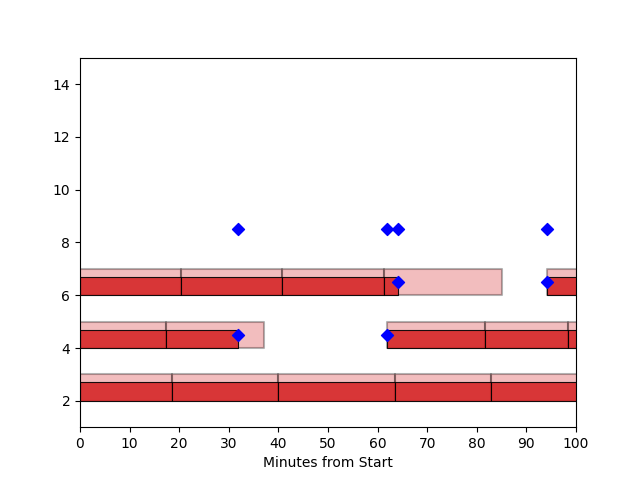

In [9]:
render_plot(filepath = r"logs/logs_repairman_1.json")

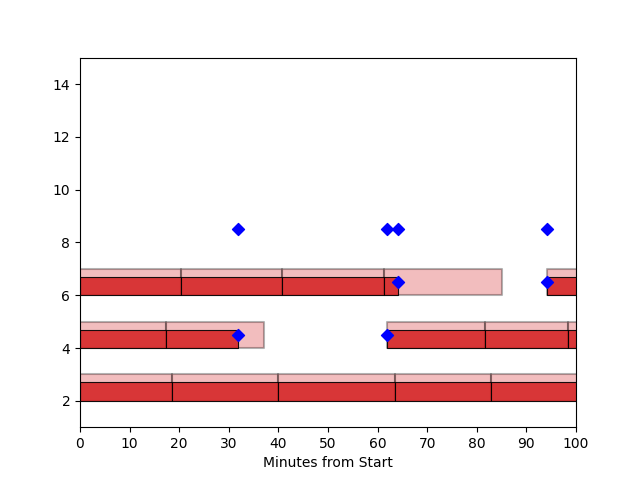

In [10]:
render_plot(filepath = r"logs/logs_repairman_2.json")